## Compare three types of models
#### LinearRegression, Tree-based, and time-series models

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import joblib

In [2]:
# load data
data_path = Path('../database/i10-broadway')
X_full = pd.read_parquet(data_path / 'X_full_1h.parquet')
print('X_full type:', type(X_full), 'shape:', getattr(X_full, 'shape', None))

X_full type: <class 'pandas.core.frame.DataFrame'> shape: (118700, 31)


In [10]:
# load models
lr_path = '../models/lr_models_log.pkl'
tree_path = '../models/tree_models_log.pkl'
xgb_path = '../models/xgb_models_log.pkl'
sarimax_path = '../models/sarimax_results.pkl'
lr_res = joblib.load(lr_path)
tree_res = joblib.load(tree_path)
xgb_res = joblib.load(xgb_path)
sarimax_res = joblib.load(sarimax_path)

# Print model names
print("Loaded models:")
print(f" - Linear Regression: {lr_res.keys()}")
print(f" - Decision Tree: {tree_res.keys()}")
print(f" - XGBoost: {xgb_res.keys()}")
print(f" - SARIMAX: {sarimax_res['Config'].unique()}")

Loaded models:
 - Linear Regression: dict_keys(['lr_base', 'lr_base_lags', 'lr_full', 'lr_cyc', 'lr_cyc_lags', 'lr_evt', 'lr_evt_lags', 'ridge_full', 'lasso_full'])
 - Decision Tree: dict_keys(['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_cyc_lags', 'rf_evt', 'rf_evt_lags', 'rf_full', 'gbrt_base', 'gbrt_base_lags', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags', 'gbrt_full'])
 - XGBoost: dict_keys(['xgb_base', 'xgb_base_lags', 'xgb_cyc', 'xgb_cyc_lags', 'xgb_evt', 'xgb_evt_lags', 'xgb_full'])
 - SARIMAX: ['base' 'evt_total' 'evt' 'cyc' 'full']


In [18]:
# Set up training and testing data

# =====Choose target and exogenous variables=====
TARGET_COL = 'travel_time_seconds'
TMC = '115+04187'
CONFIG_NAME = 'full'  # 'base', 'evt_total', 'evt', 'cyc', 'full'
# =============================================

grp = X_full.xs(TMC, level='tmc_code').sort_index(level='time_bin')
time_series = grp.index.get_level_values('time_bin')
# tmc_miles = grp['miles'].iloc[0]
n_test = int(len(grp) * 0.2)
y_train = grp[TARGET_COL].iloc[:-n_test].values
y_test  = grp[TARGET_COL].iloc[-n_test:].values

# print(f"Training samples: {len(y_train)}, Testing samples: {len(y_test)}")

In [6]:
# Select features based on configuration
time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
evt_features = ['evt_cat_unplanned', 'evt_cat_planned']
lag_features = ['log_lag1_tt_per_mile', 'log_lag2_tt_per_mile', 'log_lag3_tt_per_mile']
tmc_features = ['miles', 'reference_speed', 'curve','onramp', 'offramp']
full_features = time_features + evt_features + lag_features + tmc_features

regressors = {
    'base': tmc_features,
    'base_lags': tmc_features + lag_features,
    'full': full_features,
    'cyc':  time_features + tmc_features,
    'cyc_lags':  time_features + tmc_features + lag_features,
    'evt': evt_features + tmc_features,
    'evt_lags':evt_features + tmc_features + lag_features,
}

In [ ]:
# visualize in heatmap
import seaborn as sns
def plot_heatmap_travel_time(
    preds,                      # np.ndarray or torch.Tensor [T, N]
    time_index,                 # iterable of timestamps (aligned with preds)
    tmc_order,                  # list of TMC codes or ordered segments
    title="Predicted Travel Time Heatmap",
    cmap='viridis',
    vmin=None,
    vmax=None,
    freq=None,                  # Optional resample frequency (e.g., '1H')
    agg='mean'
):
    """
    Plot a spatio-temporal heatmap for travel time predictions from any model.

    Args:
        preds (array): [T, N] predictions (timesteps × TMCs)
        time_index (array-like): time labels for each row in preds
        tmc_order (array-like): ordered TMC codes (columns)
        title (str): plot title
        cmap (str): colormap
        vmin, vmax (float): color scale bounds
        freq (str): optional pandas resample frequency (e.g. '1H')
        agg (str): aggregation method if resampling
    """
    # Convert tensors → NumPy
    if hasattr(preds, "detach"):
        preds = preds.detach().cpu().numpy()
    elif isinstance(preds, list):
        preds = np.array(preds)

    # Build DataFrame [time × tmc]
    df_heat = pd.DataFrame(preds, index=pd.to_datetime(time_index), columns=tmc_order)

    # Optional temporal aggregation (resample)
    if freq is not None and isinstance(df_heat.index, pd.DatetimeIndex):
        df_heat = df_heat.resample(freq).agg(agg)

    # ---- Plot heatmap ----
    plt.figure(figsize=(14, 6))
    ax = sns.heatmap(
        df_heat.T,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        cbar_kws={'label': 'Travel Time per Mile (seconds)'},
        mask=df_heat.T.isna()
    )
    ax.set_title(title)
    ax.set_xlabel("Time")
    ax.set_ylabel("TMC (ordered index)")

    # --- Format x-axis tick labels (drop last 10 characters) ---
    xticklabels = [label.get_text()[:-10] for label in ax.get_xticklabels()]
    ax.set_xticklabels(xticklabels, rotation=90, ha='center')

    plt.tight_layout()
    plt.show()

    return df_heat

=== xgb_base ===


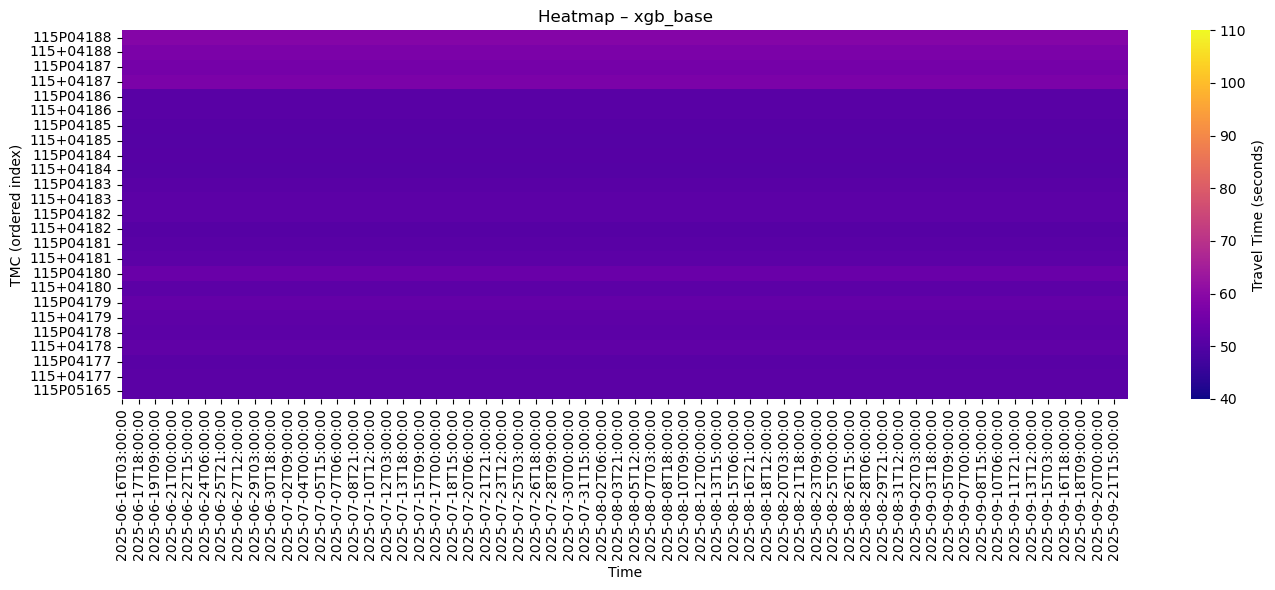

=== xgb_base_lags ===


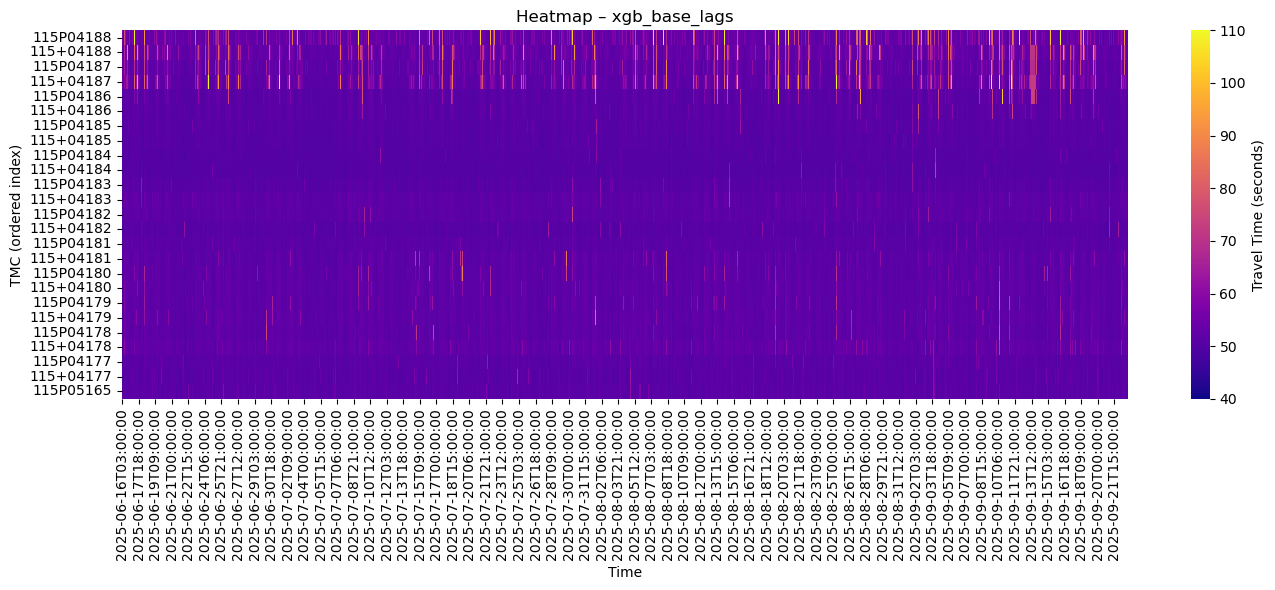

=== xgb_cyc ===


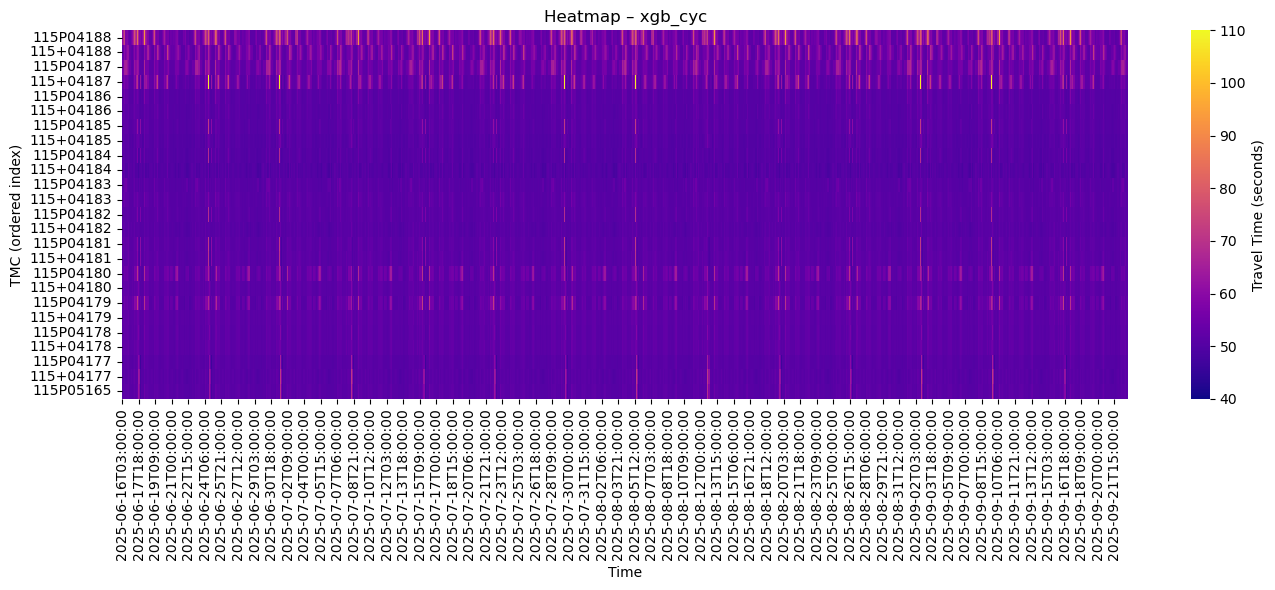

=== xgb_cyc_lags ===


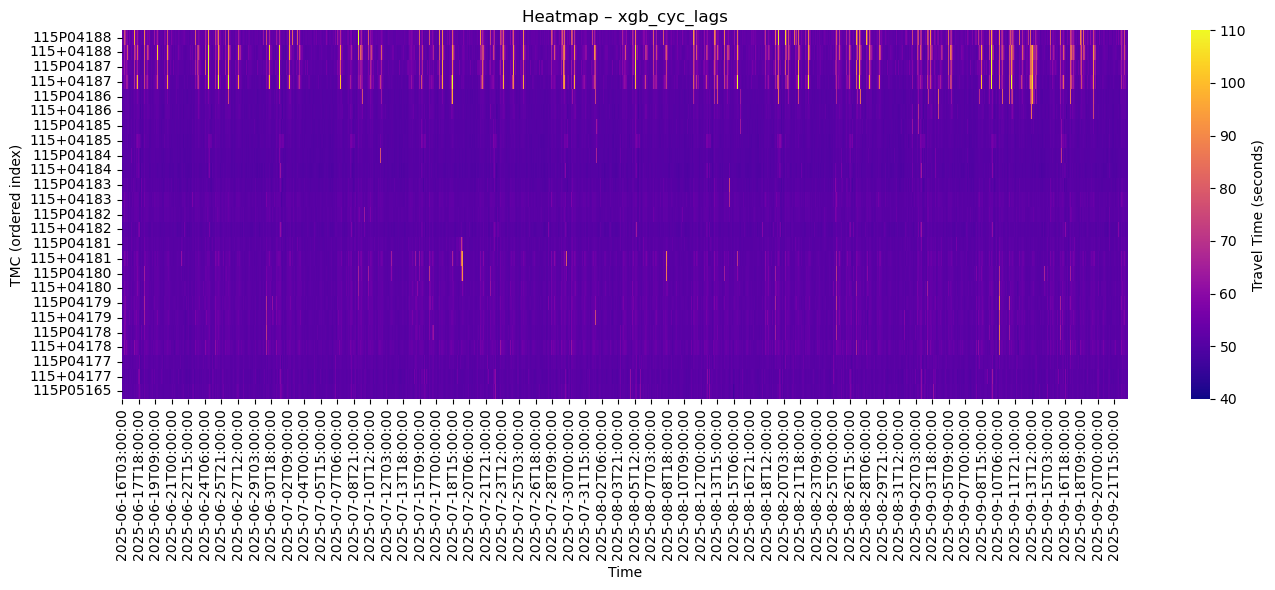

=== xgb_evt ===


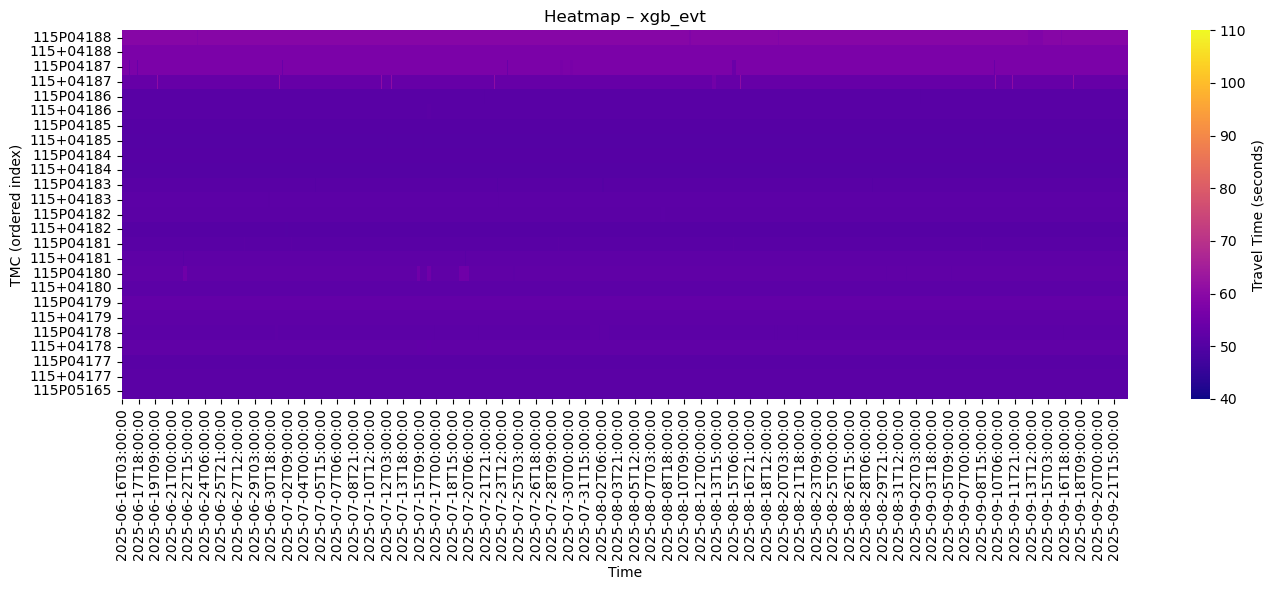

=== xgb_evt_lags ===


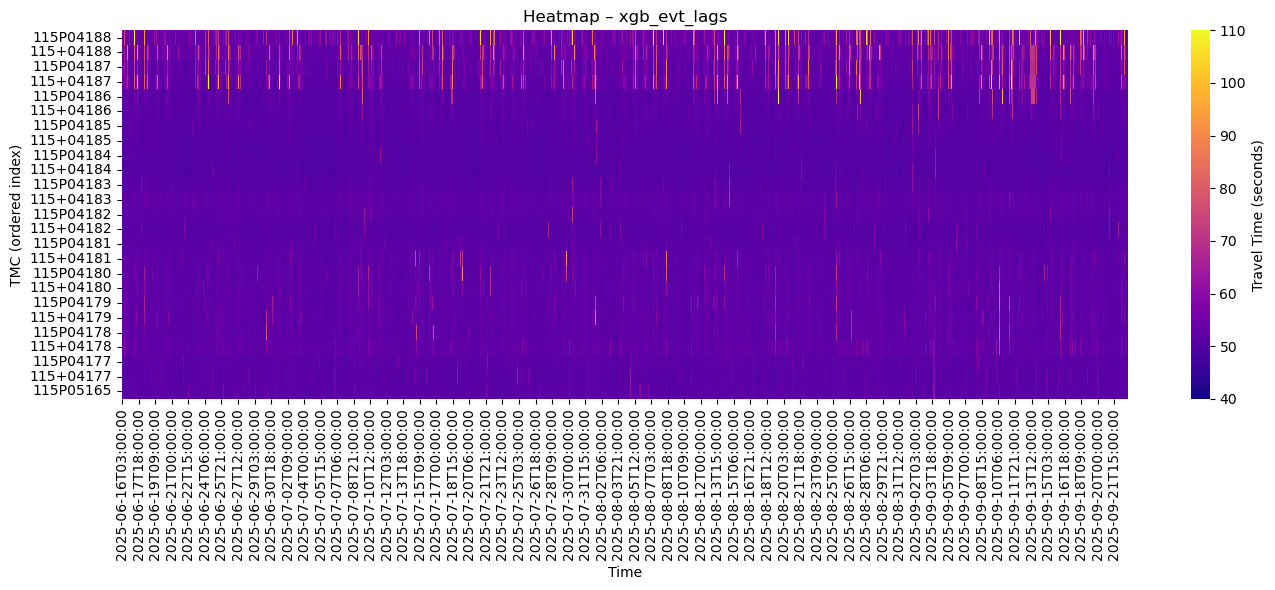

=== xgb_full ===


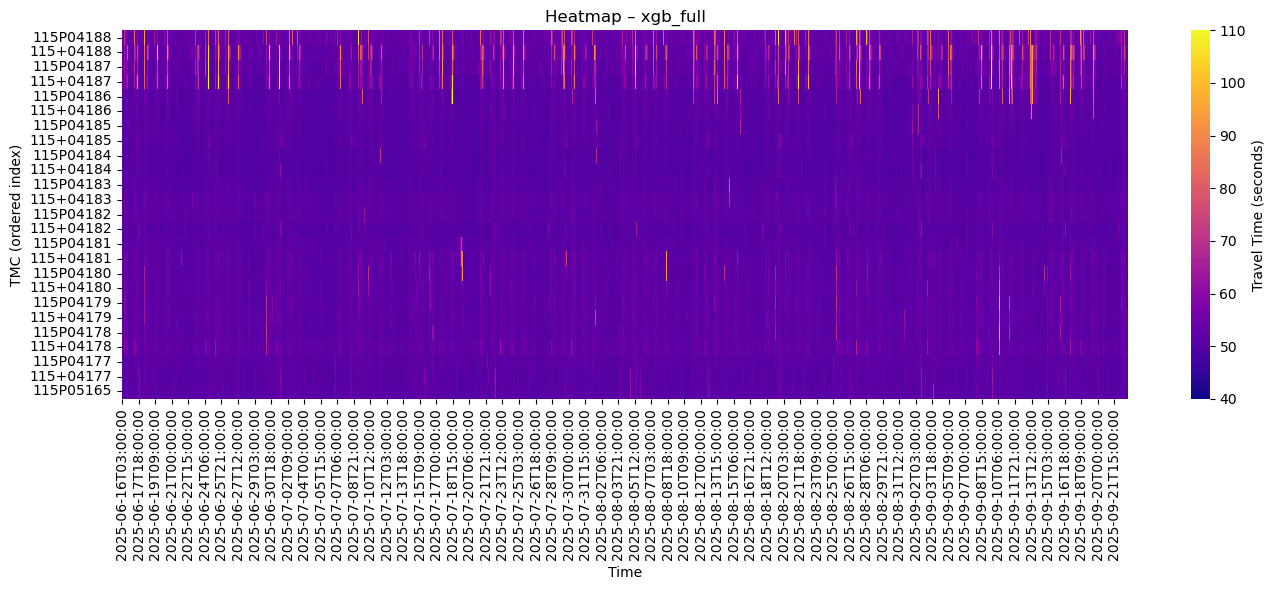

In [15]:
# heatmap
CANDIDATES = xgb_res.keys()

# Unique TMCs (nodes) and timestamps
tmc_order_dict = {
    'WB': ['115P04188', '115+04188', '115P04187', '115+04187', '115P04186', '115+04186', '115P04185', '115+04185', '115P04184', '115+04184', '115P04183', '115+04183', '115P04182', '115+04182', '115P04181', '115+04181', '115P04180', '115+04180', '115P04179', '115+04179', '115P04178', '115+04178', '115P04177', '115+04177', '115P05165'],
    'EB': ['115N04188', '115-04187', '115N04187', '115-04186', '115N04186', '115-04185', '115N04185', '115-04184', '115N04184', '115-04183', '115N04183', '115-04182', '115N04182', '115-04181', '115N04181', '115-04180', '115N04180', '115-04179', '115N04179', '115-04178', '115N04178', '115-04177', '115N04177', '115-05165', '115N05165']
}
time_index = sorted(X_full.index.get_level_values('time_bin').unique())
tmc_order = tmc_order_dict['WB']
N = len(tmc_order)
T = len(time_index)

# Chronological split
test_frac = 0.2
n_test = int(T * test_frac)

# Prepare storage for heatmaps
for candidate in CANDIDATES:
    model_key = candidate.split('_', 1)[1]
    model = xgb_res.get(candidate)

    if model is None:
        print(f"Model {candidate} not found.")
        continue

    print(f"=== {candidate} ===")

    # Build feature matrices for all TMCs and all timesteps
    feature_cols = regressors[model_key]

    preds_full = []
    for tmc in tmc_order:
        grp = X_full.xs(tmc, level='tmc_code').sort_index(level='time_bin')
        X_tmc = grp[feature_cols]
        pred = model.predict(X_tmc)
        preds_full.append(pred)

    preds_full = np.array(preds_full)  # Now shape is [N, T]

    # Now reshape to [T, N]
    preds_2d = preds_full.T

    # Plot heatmap of predictions
    plot_heatmap_travel_time(
        preds=preds_2d,
        time_index=time_index,
        tmc_order=tmc_order,
        title=f"Heatmap – {candidate}",
        cmap='plasma',
        vmin=40, vmax=110
    )

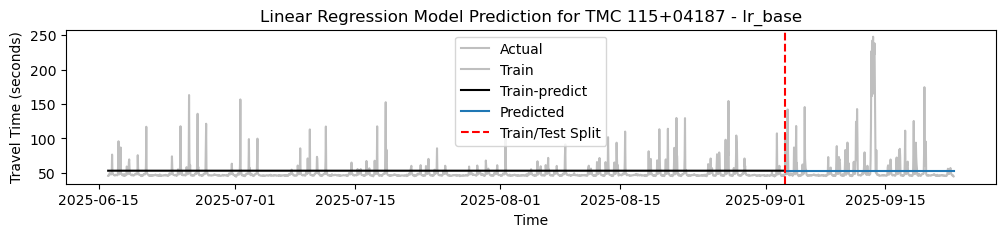

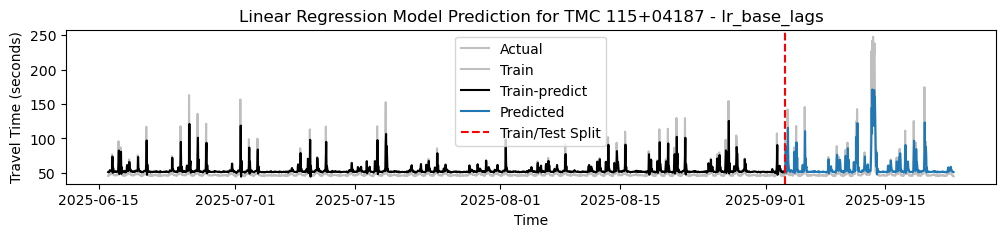

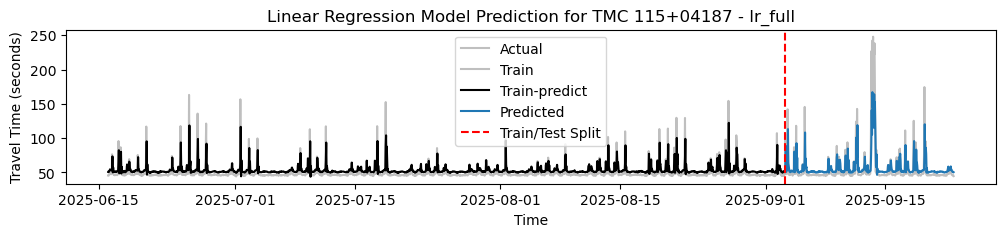

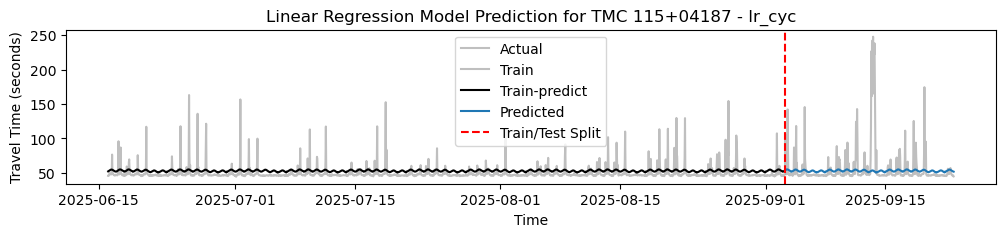

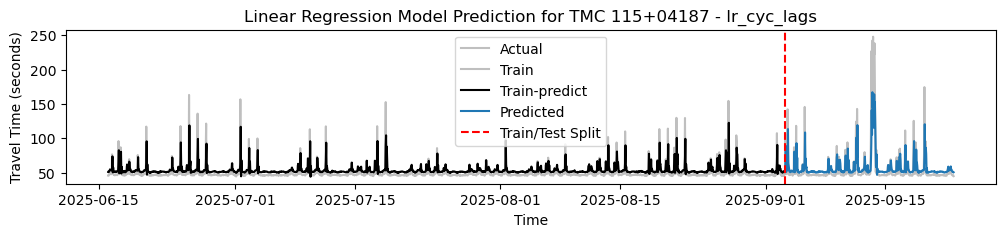

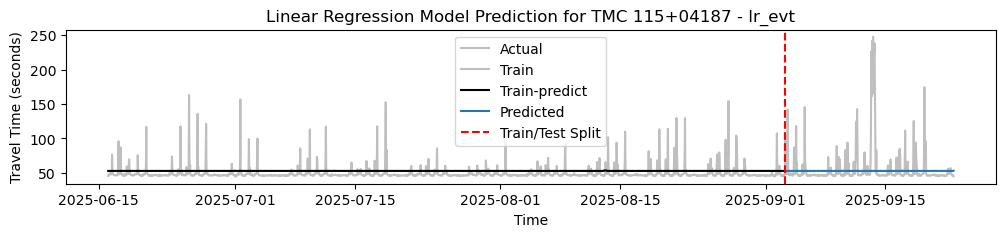

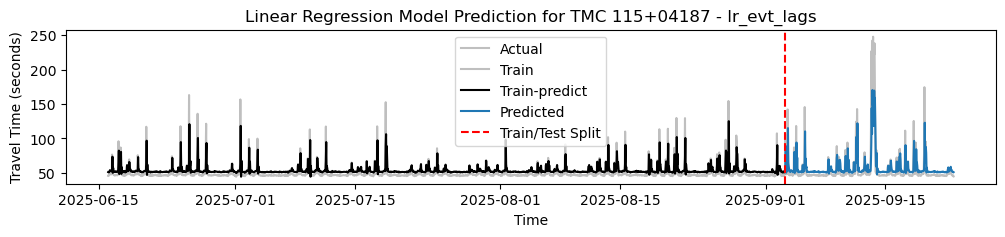

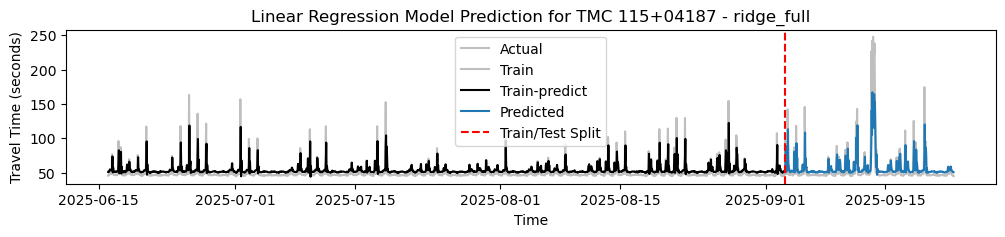

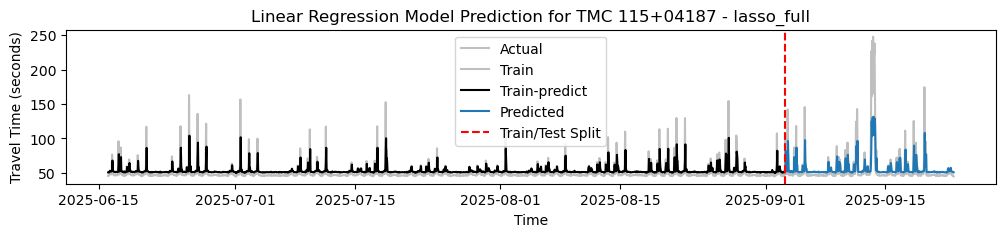

In [15]:
# Visualize lr model predictions
CANDIDATES = lr_res.keys()
# time_features = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'hour_of_week', 'hour_of_week_sin', 'hour_of_week_cos', 'is_weekend']
# evt_features = ['evt_total', 'evt_cat_major', 'evt_cat_minor', 'evt_cat_closure', 'evt_cat_obstruction', 'evt_cat_misc']
# lag_features = ['lag1', 'lag2', 'lag3']
# tmc_features = ['miles']


for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in lr_res:
        model = lr_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Linear Regression models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Linear Regression Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

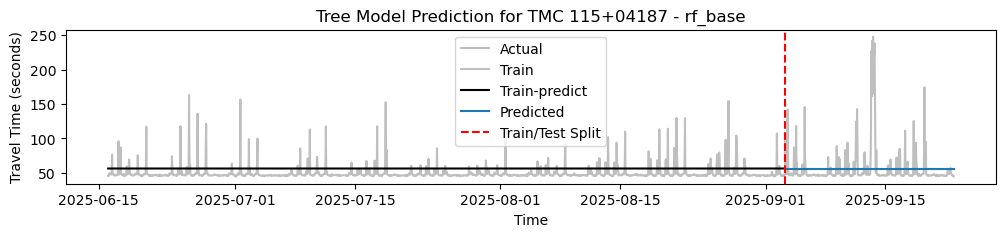

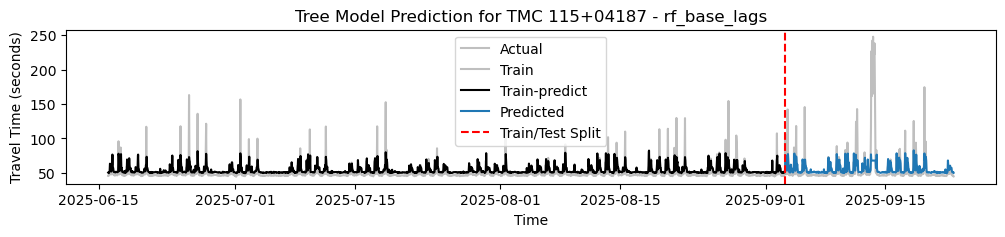

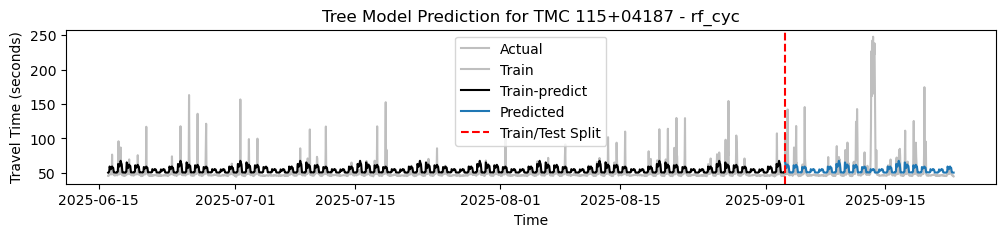

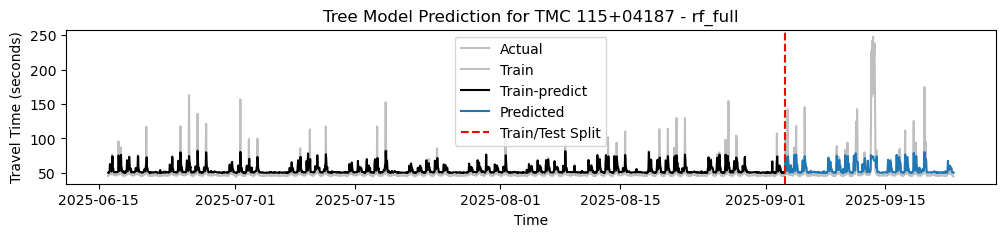

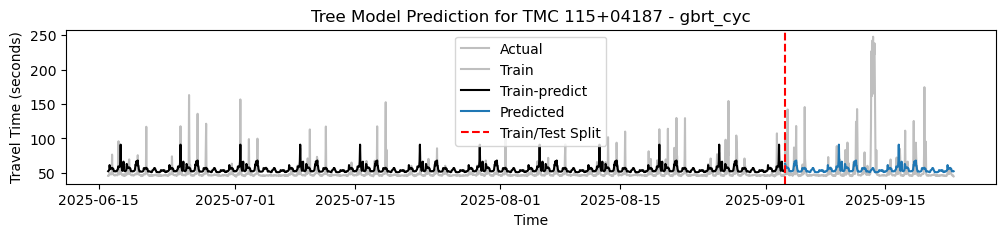

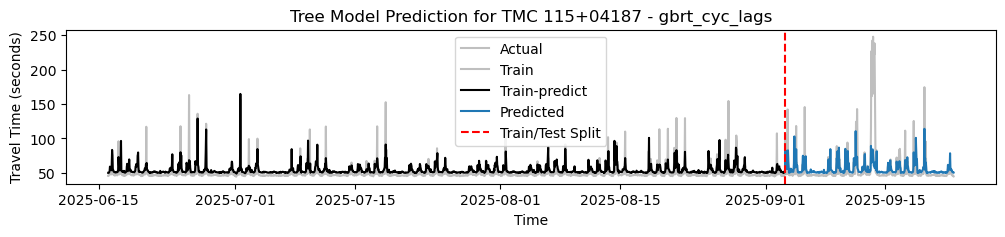

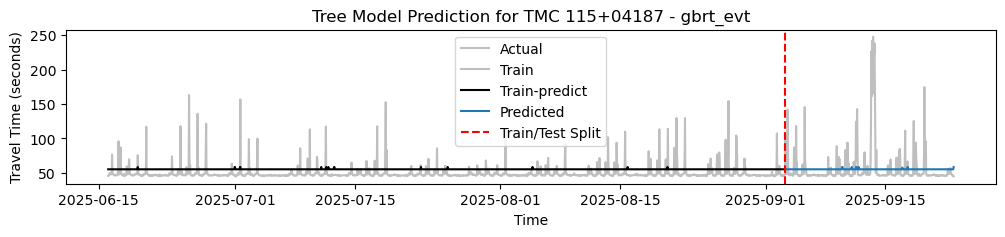

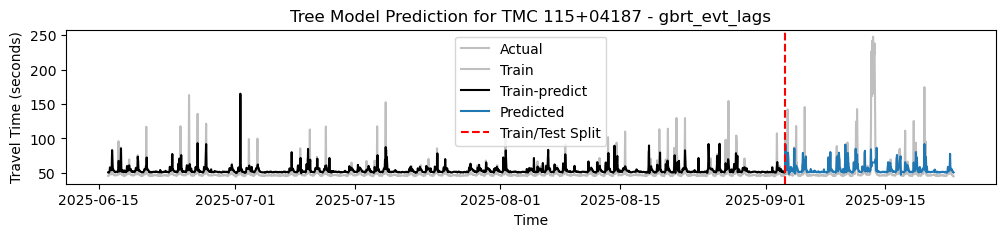

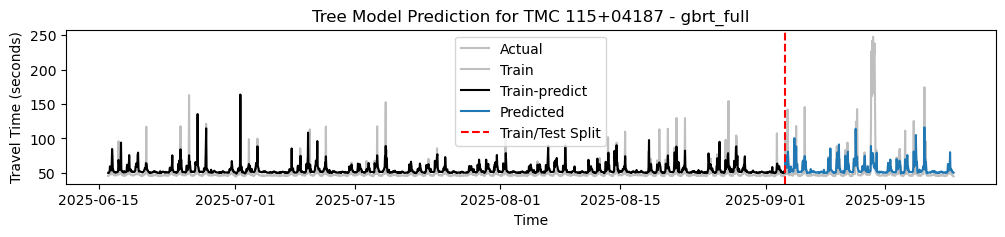

In [16]:
# Visualize tree model predictions
CANDIDATES = ['rf_base', 'rf_base_lags', 'rf_cyc', 'rf_full', 'gbrt_cyc', 'gbrt_cyc_lags', 'gbrt_evt', 'gbrt_evt_lags','gbrt_full']
for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in tree_res:
        model = tree_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded Tree models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'Tree Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

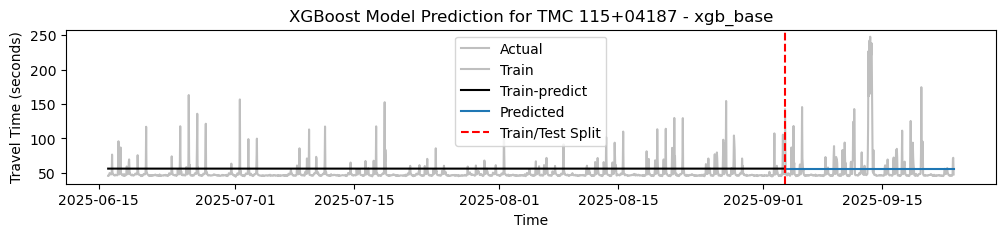

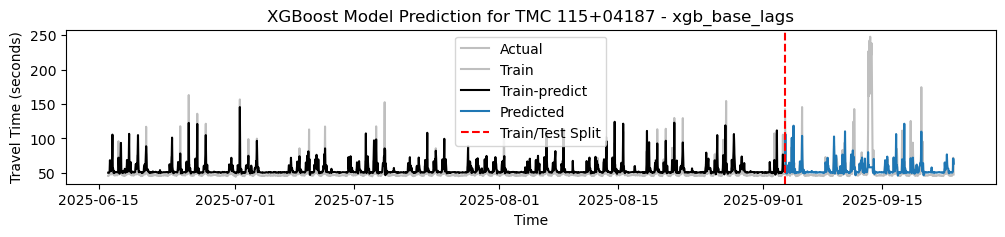

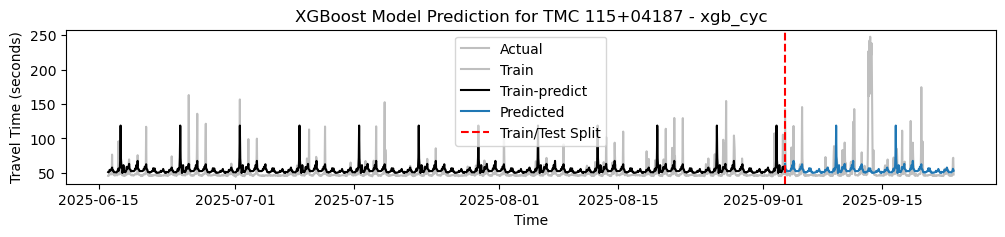

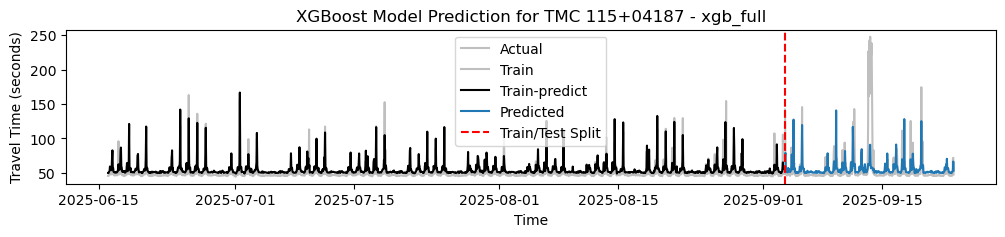

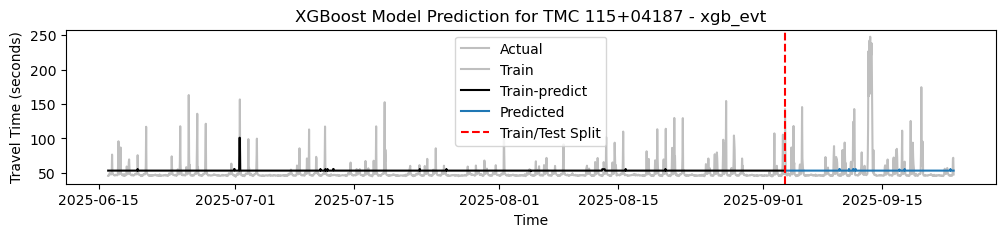

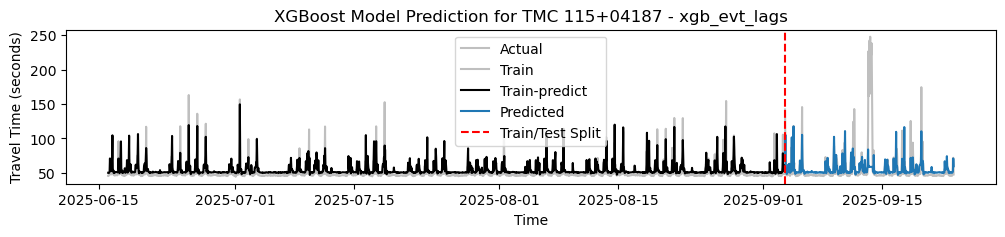

In [15]:
# Visualize XGBoost model predictions
CANDIDATES = ['xgb_base', 'xgb_base_lags', 'xgb_cyc', 'xgb_full', 'xgb_evt', 'xgb_evt_lags']
for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    regressor = regressors[candidate.split('_', 1)[1]]
    X_train = grp[regressor].iloc[:-n_test]
    X_test  = grp[regressor].iloc[-n_test:]
    if candidate in xgb_res:
        model = xgb_res[candidate]
        # print(model.get_params())
        pred_in = model.predict(X_train)
        pred = model.predict(X_test)

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded XGBoost models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'XGBoost Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

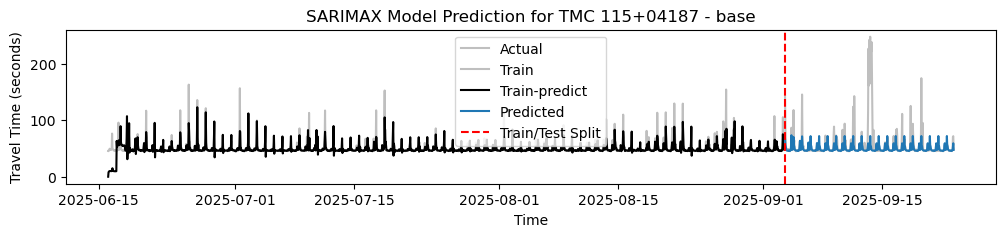

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


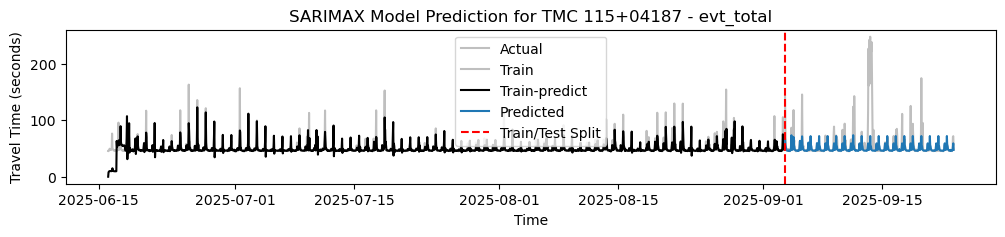

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


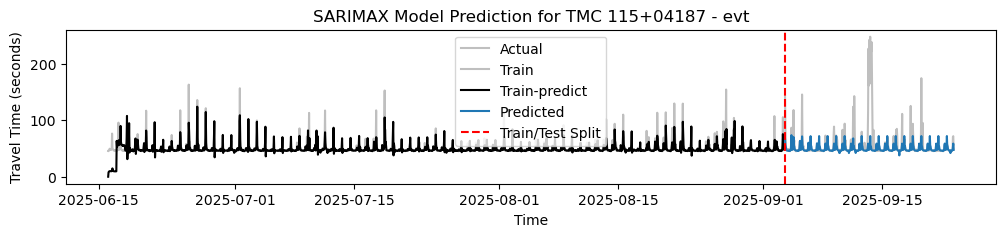

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


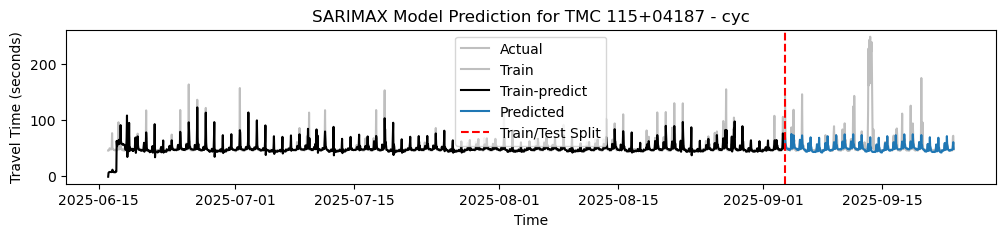

/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/home/ywan1649/.conda/envs/kafka/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


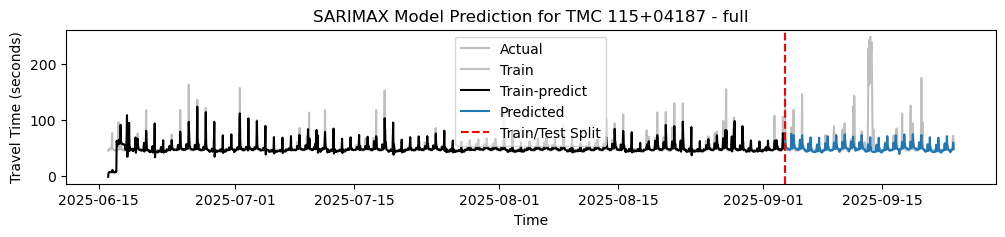

In [43]:
# Visualize time-series model predictions
# Fitting models on the fly will take some time
CANDIDATES = ['base', 'evt_total', 'evt', 'cyc', 'full']
exog_features = {
    "base": None,
    "evt_total": ["evt_total"],
    "evt": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc'],
    "cyc": ['hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend'],
    "full": ['evt_cat_minor', 'evt_cat_major','evt_cat_closure','evt_cat_obstruction', 'evt_cat_misc',
            'hour_sin','hour_cos','dow_sin','dow_cos','hour_of_week_sin','hour_of_week_cos','is_weekend']
}
# exog_cols = exog_features[CONFIG_NAME]

for candidate in CANDIDATES:
    plt.figure(figsize=(12,2))
    plt.plot(time_series[-n_test:], y_test, label='Actual', color='gray', alpha=0.5)
    plt.plot(time_series[:-n_test], y_train, label='Train', color='gray', alpha=0.5)
    if candidate in sarimax_res['Config'].values:
        
        exog = exog_features[candidate]
        if exog is None:
            X_train = None
            X_test = None
        else:
            X_train = grp[exog].iloc[:-n_test]
            X_test  = grp[exog].iloc[-n_test:]

        model = sm.tsa.statespace.SARIMAX(y_train, exog=X_train, order=(1,0,0), seasonal_order=(1,1,1,24),
                                          enforce_stationarity=False, enforce_invertibility=False)
        results = model.fit(disp=False)
        pred_in = results.fittedvalues
        pred = results.get_forecast(steps=n_test, exog=X_test).predicted_mean

        plt.plot(time_series[:-n_test], pred_in, label='Train-predict', color='black')
        plt.plot(time_series[-n_test:], pred, label='Predicted')
     
    else:
        print(f"Model {candidate} not found in loaded SARIMAX models.")

    plt.axvline(x=time_series[-n_test], color='red', linestyle='--', label='Train/Test Split')
    plt.title(f'SARIMAX Model Prediction for TMC {TMC} - {candidate}')
    plt.xlabel('Time')
    plt.ylabel('Travel Time (seconds)')
    plt.legend()
    plt.show()

## Interpret feature importance

In [ ]:
import statsmodels.api as sm
def extract_lr_coefficients(model, feature_names):
    """Extract feature coefficients from a fitted linear model inside a pipeline."""
    # Access the underlying LinearRegression estimator
    lr = model.regressor_.named_steps['reg']
    coefs = lr.coef_
    return pd.DataFrame({
        'feature': feature_names,
        'coef': coefs,
        'abs_coef': np.abs(coefs)
    }).sort_values('abs_coef', ascending=False)

def get_lr_importances(model):
    X_train_scaled = model.regressor_.named_steps['pre'].transform(X_train)
    ols = sm.OLS(y_train, sm.add_constant(X_train_scaled)).fit()
    print(ols.summary())

def get_tree_importances(model, feature_names):
    tree = model.regressor_.named_steps['reg']
    importances = tree.feature_importances_
    return pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

In [7]:
coef_df = extract_lr_coefficients(lr_res['lr_full'], full_features)
display(coef_df.head(10))

tree_df = get_tree_importances(xgb_res['xgb_full'], full_features)
display(tree_df.head(10))

,feature,coef,abs_coef
9,log_lag1_tt_per_mile,0.060599,0.060599
10,log_lag2_tt_per_mile,-0.018072,0.018072
11,log_lag3_tt_per_mile,0.012557,0.012557
1,hour_cos,-0.008593,0.008593
14,curve,0.006054,0.006054
13,reference_speed,0.005998,0.005998
4,hour_of_week_sin,0.005831,0.005831
12,miles,0.005013,0.005013
2,dow_sin,-0.004672,0.004672
0,hour_sin,0.004241,0.004241


,feature,importance
9,log_lag1_tt_per_mile,0.302974
10,log_lag2_tt_per_mile,0.146063
1,hour_cos,0.080227
13,reference_speed,0.063320
16,offramp,0.060669
11,log_lag3_tt_per_mile,0.056196
8,evt_cat_planned,0.047618
2,dow_sin,0.046490
4,hour_of_week_sin,0.044603
0,hour_sin,0.040173
